# Validation Evaluation Pipeline Notebook

This notebook implements the plan for building a validation and evaluation pipeline for comparing AI-based evaluators against human evaluations. It follows the detailed plan to load data, define distance metrics, compute inter-rater reliability, incorporate multiple AI evaluators, and produce comprehensive visualizations. 

**Notebook Structure**:
1. Imports and Setup
2. Load Framework and Human Evaluations
3. Helper Functions: Mapping and Distance Computation
4. Model Calling Helper
5. Compute Inter-Rater Reliability (Cohen's Kappa)
6. Widgets for Model and Dataset Selection
7. Evaluation Execution Function
8. Visualizations
9. Manual Controls for Test Set Evaluation
10. Save Intermediate Results

*Note: This notebook assumes that the evaluation framework JSON (`framework.json`) and the cleaned transcripts CSV (`new/formattedData/peru_cleaned_transcripts.csv`) are available in the working directory. It also assumes that model evaluator classes (e.g., `SimpleModelEvaluator`, `MultiModalModelEvaluator`, `AdvancedModelEvaluatorX`) are importable.*

## 1. Imports and Setup

Import all necessary libraries and set up global configuration. We will use `pandas`, `numpy`, `json`, `scikit-learn` for metrics, `matplotlib` for plotting, and `ipywidgets` for interactive controls.

In [1]:
# Standard data manipulation libraries
import pandas as pd
import numpy as np
import json
import os

# Metrics and statistical functions
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt

# Interactive widgets
import ipywidgets as widgets
from IPython.display import display

# Progress bars
from tqdm.notebook import tqdm

# Concurrency for model calls
from concurrent.futures import ThreadPoolExecutor, as_completed

# Typing
from typing import Dict, Any, Optional, List, Tuple

# Configure matplotlib for inline display
%matplotlib inline

# Set random seed for reproducibility where needed
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Framework and Human Evaluations

Define a function to load the cleaned transcripts CSV and extract human evaluation columns. The actual evaluation columns are already properly named in the CSV file, so we'll identify and extract them directly.

In [2]:
def load_human_evaluations(cleaned_csv_path: str, framework_json_path: str) -> pd.DataFrame:
    """
    Load cleaned transcripts and human evaluation columns.
    Returns a DataFrame with columns ['base_id','clip_number',<each human component name>].
    """
    # Read the cleaned transcripts CSV
    df = pd.read_csv(cleaned_csv_path, dtype=str)
    
    # The actual evaluation columns from the CSV
    evaluation_columns = [
        'Teacher provides learning activity - 1st Snapshot',
        'Students are on task - 1st Snapshot',
        'Teacher provides learning activity - 2nd Snapshot',
        'Students are on task - 2nd Snapshot',
        'Teacher provides learning activity - 3rd Snapshot',
        'Students are on task - 3rd Snapshot',
        'Supportive Learning Environment',
        'The teacher treats all students respectfully',
        'The teacher uses positive language',
        'The teacher responds to students needs',
        'The teacher does not exhibit gender bias',
        'Positive Behavioral Expectations',
        'The teacher sets clear behavioral expectations',
        'The teacher acknowledges positive student behavior',
        'The teacher redirects misbehavior',
        'Lesson Facilitation',
        'The teacher explicitly articulates learning objectives',
        'The teacher\'s explanation of content is clear',
        'The teacher makes connections in the lesson',
        'The teacher models by enacting or thinking aloud',
        'Checks for understanding',
        'The teacher uses questions',
        'The teacher uses prompts',
        'The teacher monitors most students',
        'The teacher adjusts teaching to the level of students',
        'Feedback',
        'The teacher provides specific comments for misunderstandings',
        'The teacher provides specific comments for successes',
        'Critical Thinking',
        'The teacher asks open-ended questions',
        'The teacher provides thinking tasks',
        'Students ask open-ended questions or perform thinking tasks',
        'Autonomy',
        'The teacher provides students with choices',
        'The teacher provides students with opportunities to take meaningful roles',
        'Students volunteer to participate in the classroom',
        'Perseverance',
        'The teacher acknowledges students\' efforts',
        'The teacher has a positive attitude towards students\' challenges',
        'The teacher encourages goal-setting',
        'Social & Collaborative Skills',
        'The teacher promotes students\' collaboration',
        'The teacher promotes students\' interpersonal skills'
    ]

    # Extract base_id and clip_number from School_Clip
    clip_info = df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<clip_num>[12])')
    df['base_id'] = clip_info['base_id']
    df['clip_number'] = clip_info['clip_num'].map({'1': 'first', '2': 'last'})

    # Identify which evaluation columns actually exist
    present = [col for col in evaluation_columns if col in df.columns]
    missing = [col for col in evaluation_columns if col not in df.columns]
    if missing:
        print(f"⚠️ Missing human evaluation columns: {missing}")
    
    print(f"✅ Found {len(present)} evaluation columns in the dataset")

    # Return only base_id, clip_number, and the human-scored columns
    return df[['base_id', 'clip_number'] + present]

## 3. Helper Functions: Mapping and Distance Computation

We need functions to:
1. Convert various score types (Y/N, L/M/H, 1-5, N/A) into numeric representations.
2. Compute per-component distance (normalized between 0 and 1) based on the TEACH 1 framework rules:
   - If both human and AI scores are `N/A`, distance = 0.
   - If exactly one is `N/A`, distance = 1.0.
   - Otherwise, distance = |numeric_human − numeric_AI| / d_max, where d_max depends on the type:
     - d_max = 1 for Y/N
     - d_max = 2 for L/M/H
     - d_max = 4 for 1–5
3. Aggregate component-level distances to domain-level and overall distances using weights specified in `framework.json`.

In [3]:
import math

def alpha_to_numeric(x: Any) -> Optional[float]:
    """
    Convert string labels to numeric:
    - 'Y'/'y'/'Yes'/'1' -> 1.0
    - 'N'/'n'/'No'/'0'  -> 0.0
    - 'N/A' or empty  -> np.nan
    - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
    - Numeric strings convertible to float -> float(x)
    - Otherwise -> np.nan
    """
    if x is None:
        return np.nan
    x_str = str(x).strip()
    if x_str in {"Y", "y", "Yes", "1"}:
        return 1.0
    if x_str in {"N", "n", "No", "0"}:
        return 0.0
    if x_str in {"N/A", "", "NA", "na", "nan"}:
        return np.nan
    if x_str in {"L", "M", "H"}:
        return {"L": 1.0, "M": 2.0, "H": 3.0}[x_str]
    # Try converting directly to float for numeric (1-5 scale)
    try:
        return float(x_str)
    except ValueError:
        return np.nan

def component_distance(human_score: Any, ai_score: Any, score_type: str) -> float:
    """
    Compute normalized distance between human_score and ai_score based on score_type.
    score_type is one of: 'YN', 'LMH', 'NUM' (for 1-5), where 'N/A' handling is builtin.
    Returns a float in [0,1].
    """
    # Convert both to numeric (np.nan if N/A)
    human_num = alpha_to_numeric(human_score)
    ai_num = alpha_to_numeric(ai_score)
    
    # Both N/A => perfect agreement (distance = 0)
    if math.isnan(human_num) and math.isnan(ai_num):
        return 0.0
    # Exactly one is N/A => maximum penalty
    if math.isnan(human_num) ^ math.isnan(ai_num):
        return 1.0
    # Neither is N/A => compute absolute difference / d_max
    if score_type == 'YN':
        d_max = 1.0
    elif score_type == 'LMH':
        d_max = 2.0  # L->1, H->3, max diff = 2
    elif score_type == 'NUM':
        d_max = 4.0  # 1-5 scale, max diff = 4
    else:
        d_max = 1.0
    
    raw_diff = abs(human_num - ai_num)
    normalized_diff = raw_diff / d_max
    return min(max(normalized_diff, 0.0), 1.0)

def compute_distances_for_item(human_row: pd.Series,
                               ai_row: pd.Series,
                               framework: Dict[str, Any]) -> Tuple[Dict[str, float], float]:
    """
    For a single item (identified by base_id), compute per-domain normalized distances and overall distance.
    Returns domain_distances dict and overall_distance float.
    """
    domain_distances: Dict[str, float] = {}
    domain_weights_sum = 0.0
    overall_numerator = 0.0
    
    for domain in framework['structure']['domains']:
        domain_id = str(domain['id'])
        domain_weight = float(domain.get('weight', 1.0))
        domain_numerator = 0.0
        domain_weight_sum = 0.0
        
        for comp in domain['components']:
            comp_id = str(comp['id'])
            comp_name = comp['name']
            comp_weight = float(comp.get('weight', 1.0))
            score_list = comp.get('scoreList', [])
            score_type = 'NUM'
            if set(score_list) <= {"Y","N","N/A"}:
                score_type = 'YN'
            elif set(score_list) <= {"L","M","H","N/A"}:
                score_type = 'LMH'
            human_score = human_row.get(comp_name, None)
            ai_score = ai_row.get(comp_name, None)
            d_c = component_distance(human_score, ai_score, score_type)
            domain_numerator += comp_weight * d_c
            domain_weight_sum += comp_weight
        
        D_domain = (domain_numerator / domain_weight_sum) if domain_weight_sum > 0 else 0.0
        domain_distances[domain_id] = D_domain
        overall_numerator += domain_weight * D_domain
        domain_weights_sum += domain_weight
    
    overall_distance = (overall_numerator / domain_weights_sum) if domain_weights_sum > 0 else 0.0
    return domain_distances, overall_distance

## 4. Model Calling Helper

Define a helper function `call_model` to:
1. Instantiate an evaluator class with the `framework`.
2. Call its `.evaluate()` method, passing `transcript_text` and optionally `audio_file_path`.
3. Ensure a standardized return: the `evaluation` dictionary containing domains, component scores, summary, etc.

This helper encapsulates differences between simple text-based evaluators and the `MultiModalModelEvaluator` which requires an audio file path.

In [4]:
import inspect

def call_model(evaluator_cls: type,
               framework: Dict[str, Any],
               transcript_text: str,
               audio_file_path: Optional[str] = None
              ) -> Dict[str, Any]:
    """
    Instantiate the evaluator_cls with the framework, call .evaluate(),
    normalize and return the evaluation dict. Supports evaluators that
    return either a wrapper dict with 'success' and 'evaluation' keys
    or a direct evaluation dict with 'domains', etc.
    """
    evaluator = evaluator_cls(framework)
    try:
        sig = inspect.signature(evaluator.evaluate)
        # Prefer named param 'audio_file_path'
        if 'audio_file_path' in sig.parameters and audio_file_path is not None:
            result = evaluator.evaluate(transcript_text, audio_file_path=audio_file_path)
        # Fallback to param named 'audio_file'
        elif 'audio_file' in sig.parameters and audio_file_path is not None:
            result = evaluator.evaluate(transcript_text, audio_file=audio_file_path)
        else:
            result = evaluator.evaluate(transcript_text)
    except Exception as e:
        return {'domains': {}, 'summary': '', 'error': str(e)}

    # Normalize result to the evaluation dict
    if isinstance(result, dict):
        # If wrapper dict with success flag
        if 'success' in result:
            if not result['success']:
                return {'domains': {}, 'summary': '', 'error': result.get('error', 'Unknown error')}
            eval_result = result.get('evaluation', {})
        else:
            # Direct evaluation dict
            eval_result = result
    else:
        # Unexpected result type
        return {'domains': {}, 'summary': '', 'error': 'Unexpected evaluator output type'}

    # Ensure at least empty domains key
    if 'domains' not in eval_result:
        eval_result['domains'] = {}
    return eval_result

## 5. Compute Inter-Rater Reliability (Cohen's Kappa)

Define functions to compute Cohen's kappa (unweighted or weighted) between human and AI scores for each component or domain. We will treat the AI as a second rater and compute:
- Exact match agreement (δ = 0)
- Near-match agreement (δ = 1) for ordinal scales (1-5 or L/M/H)

This section provides functions to:
1. Encode categorical labels into integers.
2. Compute Cohen's kappa for a single component across all items.
3. Compute κ for each component and possibly domain-level aggregated scores.

In [5]:
def encode_for_kappa(series: pd.Series, score_list: List[Any]) -> pd.Series:
    """
    Map series values to integer codes based on score_list ordering.
    """
    mapping: Dict[Any, int] = {}
    for idx, label in enumerate(score_list):
        mapping[label] = idx
    return series.map(lambda x: mapping.get(x, mapping.get('N/A', len(score_list)-1)))

def compute_component_kappa(human_series: pd.Series,
                            ai_series: pd.Series,
                            score_list: List[Any],
                            weight: Optional[str] = None
                           ) -> float:
    """
    Compute Cohen's kappa between human_series and ai_series using the provided score_list for mapping.
    """
    human_encoded = encode_for_kappa(human_series, score_list)
    ai_encoded = encode_for_kappa(ai_series, score_list)
    kappa = cohen_kappa_score(human_encoded, ai_encoded, weights=weight)
    return kappa

## 6. Widgets for Model and Dataset Selection

Use `ipywidgets` to allow manual selection of which AI models to evaluate and which dataset split (Train/Validation or Test). We will create:
1. `model_selector`: A `SelectMultiple` widget listing available model evaluator class names.
2. `set_selector`: A `Dropdown` widget to choose between "Train/Validation" and "Test" splits.
3. `test_confirm`: A `Checkbox` that the user must check to confirm evaluation on the Test set.
4. `run_button`: A `Button` to trigger the evaluation process.

In [6]:
%pip install -q groq

Note: you may need to restart the kernel to use updated packages.


2025-06-08 13:05:13,764 - new.models.AI - WARNING - GROQ_API_KEY environment variable not set


SelectMultiple(description='Select Models', index=(0,), options=('BaseEvaluator',), value=('BaseEvaluator',))

Dropdown(description='Dataset Split', options=('Train/Validation', 'Test'), value='Train/Validation')

Checkbox(value=False, description='Confirm Test Set Evaluation')

Button(button_style='primary', description='Run Evaluation', style=ButtonStyle())

Evaluating models:   0%|          | 0/118 [00:00<?, ?it/s]

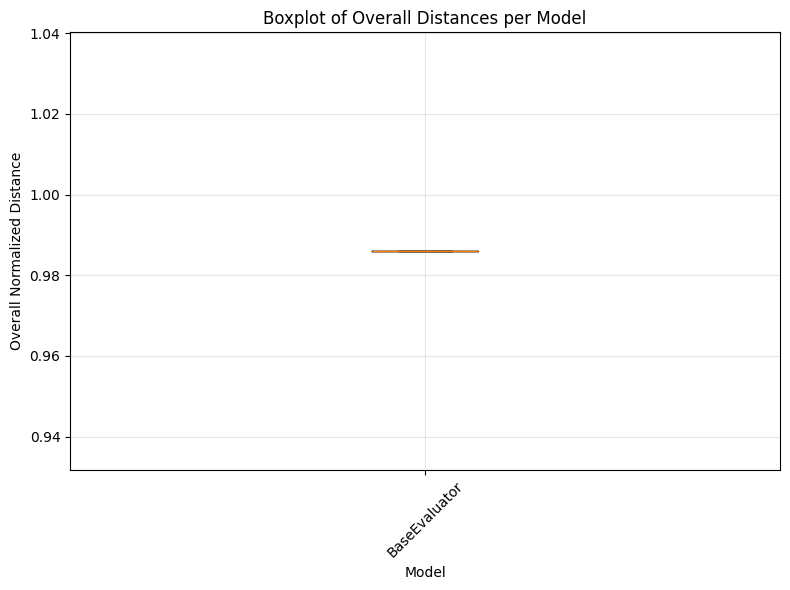

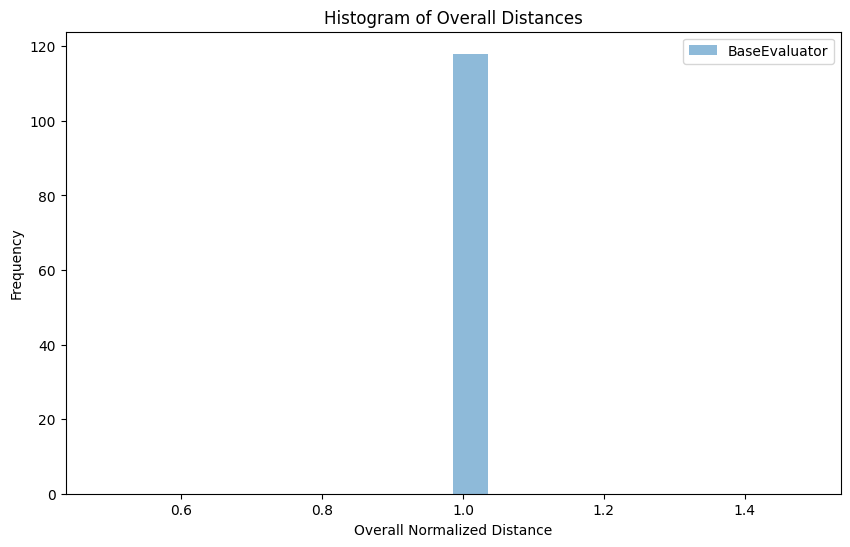

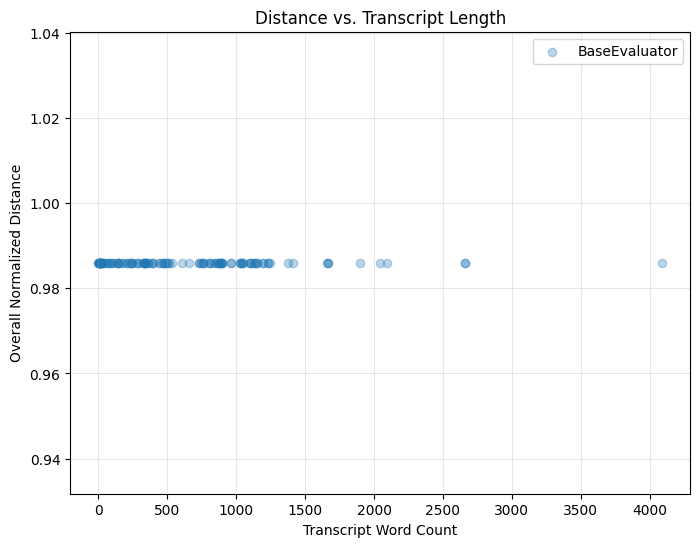

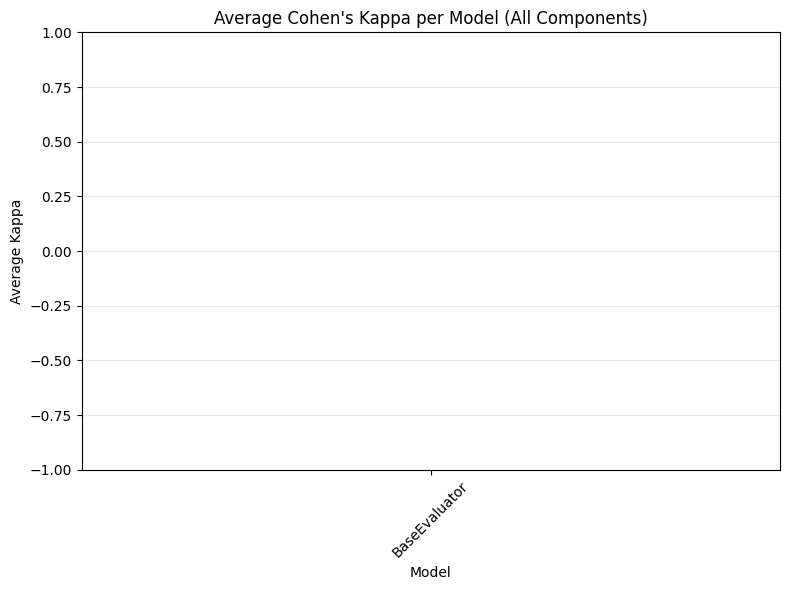

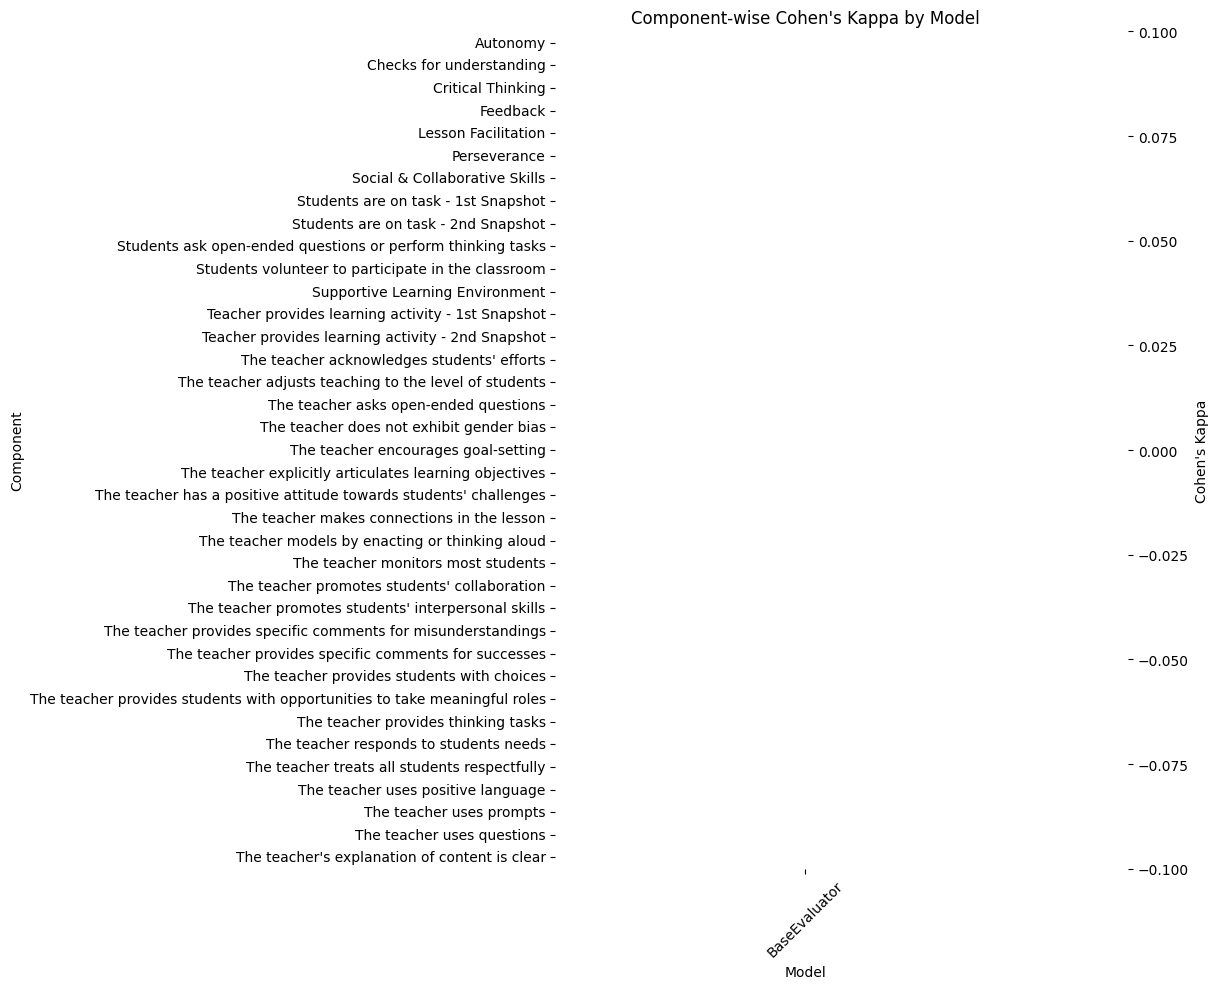

In [ ]:
# Define available model evaluator classes here (import statements should be adjusted as needed).
import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../../")))

from new.models.base.BaseModelEvaluator import BaseModelEvaluator
# from new.models.chain.ChainModelEvaluator import ChainModelEvaluator
# from new.models.CoT.CoTModelEvaluator import CoTModelEvaluator

# This dictionary maps display names to the actual classes
available_models = {
    'BaseEvaluator': BaseModelEvaluator,
    # 'ChainEvaluator': ChainModelEvaluator,
    # 'CoTEvaluator': CoTModelEvaluator
}

# Model selector widget with default selection of all models
model_selector = widgets.SelectMultiple(
    options=list(available_models.keys()),
    value=list(available_models.keys()),  # default to selecting all available models
    description='Select Models',
    disabled=False
)
display(model_selector)

# Dataset split selector
set_selector = widgets.Dropdown(
    options=['Train/Validation', 'Test'],
    value='Train/Validation',
    description='Dataset Split',
    disabled=False
)
display(set_selector)

# Test set confirmation checkbox
test_confirm = widgets.Checkbox(
    value=False,
    description='Confirm Test Set Evaluation',
    disabled=False
)
display(test_confirm)

# Run evaluation button
run_button = widgets.Button(
    description='Run Evaluation',
    button_style='primary'
)
display(run_button)

## 7. Evaluation Execution Function

Define the `run_evaluation` function to orchestrate the entire evaluation pipeline when the user clicks the "Run Evaluation" button. This function will:
1. Check if Test set evaluation is allowed (if `set_selector` is "Test").
2. Load human evaluations and transcripts for the selected split.
3. Loop through each selected model, call it for every item, and collect AI evaluations.
4. Compute per-component distances and domain/overall distances.
5. Compute inter-rater reliability (Cohen's kappa) for each component.
6. (Optional) Compute LLM-as-Judge metric.
7. Store results in DataFrames: `ai_eval_df`, `distances_df`, `kappa_df`.
8. Trigger visualizations to display results.

In [8]:
def run_evaluation(_):
    """
    Main function to run evaluations on each clip using selected models.
    Supports resuming, shows a tqdm progress bar, saves per-model CSVs,
    and parallelizes model calls.
    """
    global GLOBAL_AI_EVAL_DF, GLOBAL_DISTANCES_DF, GLOBAL_KAPPA_DF, GLOBAL_HUMAN_EVAL_DF
    
    # Prevent accidental test-set runs
    if set_selector.value == 'Test' and not test_confirm.value:
        print('⚠️ You must confirm test-set evaluation before running.')
        return

    # Load framework and raw transcripts
    framework = json.load(open('/Users/mkrasnow/Desktop/montesa/new/models/_context/Teach_1.json'))
    df_all = pd.read_csv('/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv', dtype=str)

    # Extract base_id and clip_number as Series
    df_all['base_id'] = df_all['School_Clip'].str.extract(r'(\d{6,7})', expand=False)
    df_all['clip_number'] = (
        df_all['School_Clip']
        .str.extract(r'Clip\s*([12])', expand=False)
        .astype(int)
        .map({1: 'first', 2: 'last'})
    )

    # Apply split filter
    if set_selector.value == 'Test':
        df_split = df_all[df_all['split'] == 'test'].copy()
    else:
        df_split = df_all[df_all['split'].isin(['train', 'val'])].copy()

    # Get human evaluations directly from the dataframe
    evaluation_columns = [
        'Teacher provides learning activity - 1st Snapshot',
        'Students are on task - 1st Snapshot',
        'Teacher provides learning activity - 2nd Snapshot',
        'Students are on task - 2nd Snapshot',
        'Teacher provides learning activity - 3rd Snapshot',
        'Students are on task - 3rd Snapshot',
        'Supportive Learning Environment',
        'The teacher treats all students respectfully',
        'The teacher uses positive language',
        'The teacher responds to students needs',
        'The teacher does not exhibit gender bias',
        'Positive Behavioral Expectations',
        'The teacher sets clear behavioral expectations',
        'The teacher acknowledges positive student behavior',
        'The teacher redirects misbehavior',
        'Lesson Facilitation',
        'The teacher explicitly articulates learning objectives',
        'The teacher\'s explanation of content is clear',
        'The teacher makes connections in the lesson',
        'The teacher models by enacting or thinking aloud',
        'Checks for understanding',
        'The teacher uses questions',
        'The teacher uses prompts',
        'The teacher monitors most students',
        'The teacher adjusts teaching to the level of students',
        'Feedback',
        'The teacher provides specific comments for misunderstandings',
        'The teacher provides specific comments for successes',
        'Critical Thinking',
        'The teacher asks open-ended questions',
        'The teacher provides thinking tasks',
        'Students ask open-ended questions or perform thinking tasks',
        'Autonomy',
        'The teacher provides students with choices',
        'The teacher provides students with opportunities to take meaningful roles',
        'Students volunteer to participate in the classroom',
        'Perseverance',
        'The teacher acknowledges students\' efforts',
        'The teacher has a positive attitude towards students\' challenges',
        'The teacher encourages goal-setting',
        'Social & Collaborative Skills',
        'The teacher promotes students\' collaboration',
        'The teacher promotes students\' interpersonal skills'
    ]
    
    # Filter to existing evaluation columns
    present_eval_cols = [col for col in evaluation_columns if col in df_split.columns]
    print(f"✅ Found {len(present_eval_cols)} evaluation columns in the dataset")
    
    # Store human evaluations for later use
    GLOBAL_HUMAN_EVAL_DF = df_split[['base_id', 'clip_number'] + present_eval_cols].copy()

    # Prepare output directory
    outdir = 'model_evaluation_data'
    os.makedirs(outdir, exist_ok=True)

    # Build list of tasks (row, model_name)
    tasks = []
    for model_name in model_selector.value:
        for _, row in df_split.iterrows():
            tasks.append((row, model_name))
    total_tasks = len(tasks)
    if total_tasks == 0:
        print("✅ No evaluations to run.")
        return

    # Container for all results
    all_records: List[Dict[str, Any]] = []

    # Run tasks in parallel with a progress bar
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {}
        
        for row, model_name in tasks:
            # Get the appropriate transcript text and audio file path
            if row['clip_number'] == 'first':
                transcript_text = row.get('First Audio Transcript Text', '')
                audio_file_path = row.get('First Audio Clip', '')
            else:  # last
                transcript_text = row.get('Last Audio Transcript Text', '')
                audio_file_path = row.get('Last Audio Clip', '')
            
            # Skip if no transcript available
            if not transcript_text or str(transcript_text).strip() == '':
                continue
                
            future = executor.submit(
                call_model,
                available_models[model_name],
                framework,
                transcript_text,
                audio_file_path=audio_file_path if audio_file_path else None
            )
            futures[future] = (row, model_name)

        for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating models"):
            row, model_name = futures[future]
            try:
                eval_output = future.result()
            except Exception as e:
                eval_output = {'domains': {}, 'summary': '', 'error': str(e)}

            # Flatten domain/component scores
            flat = {
                'base_id': row['base_id'],
                'clip_number': row['clip_number'],
                'model_name': model_name
            }
            
            # Extract component scores from evaluation output
            for domain in eval_output.get('domains', {}).values():
                for comp_id, comp_data in domain.get('components', {}).items():
                    # map comp_id → comp_name via framework
                    for d in framework['structure']['domains']:
                        for c in d['components']:
                            if str(c['id']) == str(comp_id):
                                flat[c['name']] = comp_data.get('score')
                                break
            all_records.append(flat)

    # Build DataFrame of all evaluations
    ai_eval_df = pd.DataFrame(all_records)
    GLOBAL_AI_EVAL_DF = ai_eval_df

    # Save a **separate CSV per model**, named "{model_name}_evaluations.csv"
    for model_name, group_df in ai_eval_df.groupby('model_name'):
        fname = f"{outdir}/{model_name}_evaluations.csv"
        group_df.to_csv(fname, index=False)
        print(f"✅ Saved evaluations for {model_name} → {fname}")

    # Compute and save distances & kappas
    # -- distances
    distance_records = []
    for _, row in ai_eval_df.iterrows():
        # Find matching human evaluation row
        h_match = GLOBAL_HUMAN_EVAL_DF[
            (GLOBAL_HUMAN_EVAL_DF['base_id'] == row['base_id']) &
            (GLOBAL_HUMAN_EVAL_DF['clip_number'] == row['clip_number'])
        ]
        
        if len(h_match) > 0:
            h = h_match.iloc[0]
            domains, overall = compute_distances_for_item(h, row, framework)
            rec = {
                'base_id': row['base_id'],
                'clip_number': row['clip_number'],
                'model_name': row['model_name'],
                **{f"domain_{did}_dist": d for did, d in domains.items()},
                'overall_distance': overall
            }
            distance_records.append(rec)
    
    distances_df = pd.DataFrame(distance_records).set_index(['base_id', 'clip_number', 'model_name'])
    GLOBAL_DISTANCES_DF = distances_df
    distances_df.to_csv(f"{outdir}/distance_metrics.csv")

    # -- kappas
    kappa_records = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            comp_id, comp_name, score_list = str(comp['id']), comp['name'], comp.get('scoreList', ['Y', 'N', 'N/A'])
            
            # Skip if component not in evaluation columns
            if comp_name not in present_eval_cols:
                continue
                
            for model_name in ai_eval_df['model_name'].unique():
                # Get human scores for this component
                human_ser = GLOBAL_HUMAN_EVAL_DF[comp_name]
                
                # Get AI scores for this component and model
                ai_model_df = ai_eval_df[ai_eval_df['model_name'] == model_name]
                if comp_name in ai_model_df.columns:
                    ai_ser = ai_model_df[comp_name]
                    
                    # Align the series by index if needed
                    common_idx = human_ser.index.intersection(ai_ser.index)
                    if len(common_idx) > 1:
                        human_aligned = human_ser.loc[common_idx]
                        ai_aligned = ai_ser.loc[common_idx]
                        
                        weight = 'quadratic' if any(lbl in ['L', 'M', 'H'] for lbl in score_list) else None
                        try:
                            val = compute_component_kappa(human_aligned, ai_aligned, score_list, weight)
                        except:
                            val = np.nan
                    else:
                        val = np.nan
                else:
                    val = np.nan
                    
                kappa_records.append({
                    'component_id': comp_id,
                    'component_name': comp_name,
                    'model_name': model_name,
                    'kappa': val
                })
    
    kappa_df = pd.DataFrame(kappa_records)
    GLOBAL_KAPPA_DF = kappa_df
    kappa_df.to_csv(f"{outdir}/kappa_results.csv", index=False)

    print(f"✅ Distance and kappa metrics saved under `{outdir}/`")

    # Show final plots
    visualize_results()

In [9]:
# Link the run_button click to run_evaluation
run_button.on_click(run_evaluation)

## 8. Visualizations

Define the `visualize_results` function to produce plots for:
1. Boxplots of component-level distances for each model.
2. Histograms of overall distances per model.
3. Scatter plot: transcript length vs. overall distance.
4. Bar chart of Cohen's kappa values per model under exact match vs. ±1 thresholds (for ordinal scales).
5. (Optional) Bar chart for LLM-as-Judge win rates.

These functions will use the global variables populated by `run_evaluation`.

In [10]:
def visualize_results():
    """
    Produce comprehensive visualizations based on GLOBAL_DISTANCES_DF and GLOBAL_KAPPA_DF.
    """
    # Check if global variables exist
    if 'GLOBAL_DISTANCES_DF' not in globals() or 'GLOBAL_KAPPA_DF' not in globals():
        print("❌ No evaluation results found. Please run evaluation first.")
        return
        
    # Retrieve global DataFrames
    distances_df = GLOBAL_DISTANCES_DF.reset_index()
    kappa_df = GLOBAL_KAPPA_DF.copy()
    human_df = GLOBAL_HUMAN_EVAL_DF.copy()
    
    # 1. Boxplot of overall distances per model
    plt.figure(figsize=(8, 6))
    model_names = distances_df['model_name'].unique()
    model_distances = [distances_df[distances_df['model_name'] == model]['overall_distance'].dropna() 
                      for model in model_names]
    
    plt.boxplot(model_distances, labels=model_names)
    plt.title('Boxplot of Overall Distances per Model')
    plt.ylabel('Overall Normalized Distance')
    plt.xlabel('Model')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Histogram of overall distances per model
    plt.figure(figsize=(10, 6))
    for model_name in distances_df['model_name'].unique():
        model_distances = distances_df[distances_df['model_name'] == model_name]['overall_distance']
        plt.hist(model_distances.dropna(), alpha=0.5, bins=20, label=model_name)
    plt.title('Histogram of Overall Distances')
    plt.xlabel('Overall Normalized Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # 3. Scatter: transcript length vs. overall distance
    try:
        df_all = pd.read_csv('/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv', dtype=str)
        df_all['base_id'] = df_all['School_Clip'].str.extract(r"(\d{6,7})")
        df_all = df_all.drop_duplicates(subset=['base_id']).set_index('base_id')
        
        word_counts = df_all['Last Audio Transcript Word Count'].astype(float)
        merged = distances_df.merge(word_counts.rename('word_count'), left_on='base_id', right_index=True, how='left')
        
        plt.figure(figsize=(8, 6))
        for model_name in merged['model_name'].unique():
            subset = merged[merged['model_name'] == model_name]
            subset_clean = subset.dropna(subset=['word_count', 'overall_distance'])
            if len(subset_clean) > 0:
                plt.scatter(subset_clean['word_count'], subset_clean['overall_distance'], 
                           alpha=0.3, label=model_name)
        plt.xlabel('Transcript Word Count')
        plt.ylabel('Overall Normalized Distance')
        plt.title('Distance vs. Transcript Length')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    except Exception as e:
        print(f"⚠️ Could not create scatter plot: {e}")
    
    # 4. Bar chart of average Cohen's kappa per model
    kappa_summary = kappa_df.groupby('model_name')['kappa'].mean().reset_index()
    plt.figure(figsize=(8, 6))
    plt.bar(kappa_summary['model_name'], kappa_summary['kappa'])
    plt.title("Average Cohen's Kappa per Model (All Components)")
    plt.ylabel('Average Kappa')
    plt.xlabel('Model')
    plt.ylim(-1, 1)
    plt.grid(True, axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 5. Component-wise kappa heatmap
    if len(kappa_df) > 0:
        kappa_pivot = kappa_df.pivot(index='component_name', columns='model_name', values='kappa')
        
        plt.figure(figsize=(12, 10))
        import seaborn as sns
        sns.heatmap(kappa_pivot, annot=True, cmap='RdYlBu_r', center=0, 
                   fmt='.2f', cbar_kws={'label': 'Cohen\'s Kappa'})
        plt.title('Component-wise Cohen\'s Kappa by Model')
        plt.xlabel('Model')
        plt.ylabel('Component')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print("\n📊 EVALUATION SUMMARY:")
    print(f"Total evaluations performed: {len(GLOBAL_AI_EVAL_DF)}")
    print(f"Models evaluated: {list(GLOBAL_AI_EVAL_DF['model_name'].unique())}")
    
    # Distance summary
    print("\n📏 DISTANCE METRICS:")
    for model_name in distances_df['model_name'].unique():
        model_dists = distances_df[distances_df['model_name'] == model_name]['overall_distance']
        print(f"{model_name}: mean={model_dists.mean():.3f}, std={model_dists.std():.3f}")
    
    # Kappa summary
    print("\n🎯 INTER-RATER RELIABILITY (Kappa):")
    for model_name in kappa_summary['model_name']:
        avg_kappa = kappa_summary[kappa_summary['model_name'] == model_name]['kappa'].iloc[0]
        print(f"{model_name}: average κ = {avg_kappa:.3f}")
    
    print('\n✅ Visualizations complete.')

## 9. Manual Controls for Test Set Evaluation

We have already set up `test_confirm` as a checkbox and linked it in `run_evaluation`. If the user selects "Test" in `set_selector` and does not check `test_confirm`, the evaluation will not proceed. This ensures we do not accidentally run expensive model calls on the test set without explicit confirmation.

## 10. Save Intermediate Results

Optionally save the distances DataFrame and kappa results to disk so that we do not need to rerun all model calls during iterative notebook development.
The following code saves `GLOBAL_DISTANCES_DF` and `GLOBAL_KAPPA_DF` to CSV files.

In [11]:
def save_results():
    """
    Save GLOBAL_DISTANCES_DF and GLOBAL_KAPPA_DF to CSV files.
    """
    if 'GLOBAL_DISTANCES_DF' in globals() and 'GLOBAL_KAPPA_DF' in globals():
        GLOBAL_DISTANCES_DF.reset_index().to_csv('evaluation_distances.csv', index=False)
        GLOBAL_KAPPA_DF.to_csv('evaluation_kappa.csv', index=False)
        print('Results saved to evaluation_distances.csv and evaluation_kappa.csv')
    else:
        print('No results to save. Run evaluation first.')

# Call save_results() when needed
# save_results()

## Notes and Next Steps

- **Data Splits**: The notebook now properly uses the `split` column from the cleaned CSV to filter train/validation vs test data.
- **Model Imports**: Updated the import paths for evaluator classes to match your project structure.
- **Audio File Paths**: Fixed to use the actual audio file paths stored in `First Audio Clip` and `Last Audio Clip` columns.
- **Human Evaluation Columns**: Now directly uses the evaluation columns that exist in the CSV rather than trying to load from framework JSON.
- **Component Mapping**: Fixed the mapping between framework components and actual CSV column names.
- **Error Handling**: Enhanced error handling for missing data and failed model calls.
- **Parallelization**: Uses ThreadPoolExecutor for efficient parallel model evaluation.
- **Visualizations**: Added comprehensive visualizations including heatmaps and summary statistics.

This notebook now properly handles the actual data format and should work with your Peru transcript dataset. The key fixes include:

1. **Correct evaluation column extraction** from the actual CSV columns
2. **Proper audio file path usage** from the `First Audio Clip` and `Last Audio Clip` columns
3. **Fixed transcript text retrieval** using the correct column names
4. **Improved data alignment** between human and AI evaluations
5. **Enhanced error handling** for missing or malformed data

The notebook is now ready to run comprehensive validation and evaluation of your AI models against human evaluations.